In [1]:
import os
import re
import random
from itertools import islice

import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import gensim.downloader as api
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def set_seed(seed: int):
    # Set seed for Python's random module
    random.seed(seed)
    
    # Set seed for NumPy
    np.random.seed(seed)
    
    # Set seed for PyTorch
    torch.manual_seed(seed)
    
    # Set seed for CUDA (if using)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
        
    # Make PyTorch deterministic (this can slow down the computation)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Example of usage
set_seed(42)


In [3]:
word2vec_model = api.load('word2vec-google-news-300')

In [4]:
# https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis
dataset_path = kagglehub.dataset_download("jp797498e/twitter-entity-sentiment-analysis")

print("Path to dataset files:", dataset_path)

Path to dataset files: /home/olokshyn/.cache/kagglehub/datasets/jp797498e/twitter-entity-sentiment-analysis/versions/2


In [5]:
os.listdir(dataset_path)

['twitter_training.csv', 'twitter_validation.csv']

In [6]:
!head {os.path.join(dataset_path, "twitter_training.csv")}

2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
2401,Borderlands,Positive,"I am coming to the borders and I will kill you all,"
2401,Borderlands,Positive,"im getting on borderlands and i will kill you all,"
2401,Borderlands,Positive,"im coming on borderlands and i will murder you all,"
2401,Borderlands,Positive,"im getting on borderlands 2 and i will murder you me all,"
2401,Borderlands,Positive,"im getting into borderlands and i can murder you all,"
2402,Borderlands,Positive,So I spent a few hours making something for fun. . . If you don't know I am a HUGE @Borderlands fan and Maya is one of my favorite characters. So I decided to make myself a wallpaper for my PC. . Here is the original image versus the creation I made :) Enjoy! pic.twitter.com/mLsI5wf9Jg
2402,Borderlands,Positive,"So I spent a couple of hours doing something for fun... If you don't know that I'm a huge @ Borderlands fan and Maya is one of my favorite characters, I decided to make a 

===== Train dataset =====


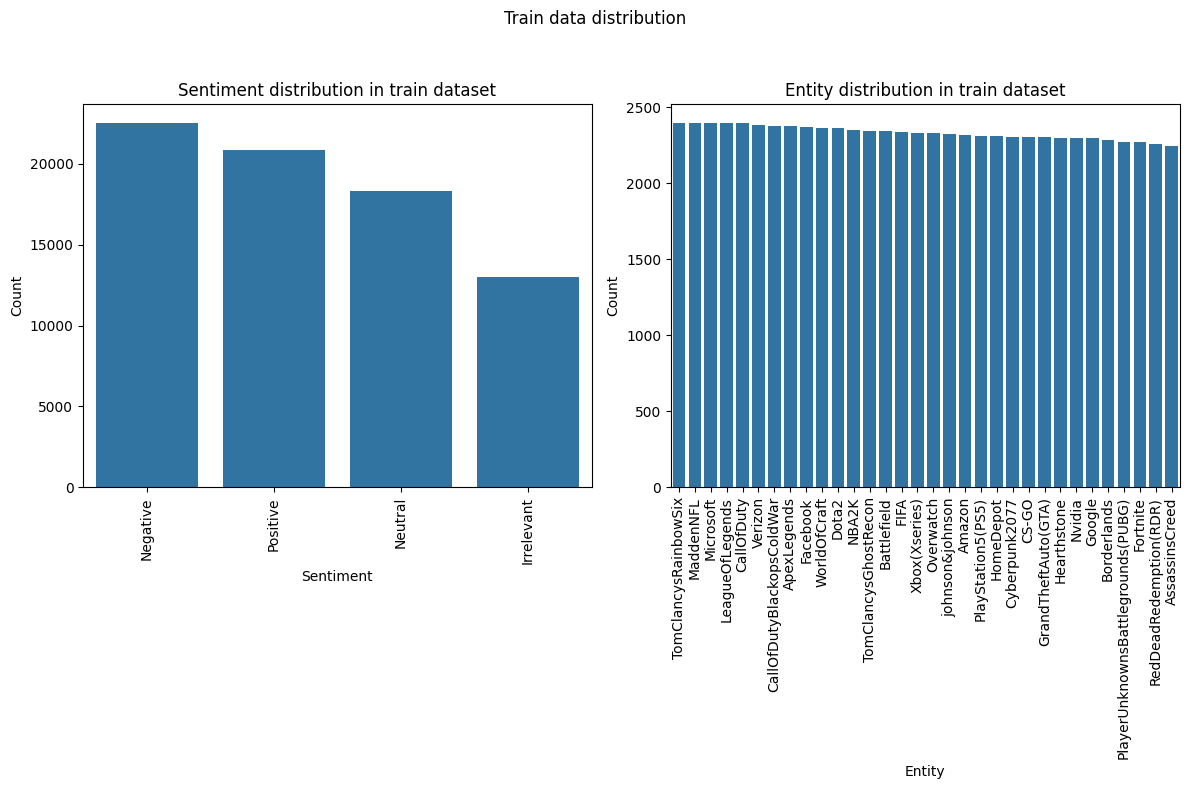

<class 'pandas.core.frame.DataFrame'>
Index: 61121 entries, 0 to 74681
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      61121 non-null  int64  
 1   entity  61121 non-null  object 
 2   label   61121 non-null  object 
 3   text    61121 non-null  object 
 4   target  61121 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 2.8+ MB


,id,target
count,61121.000000,61121.000000
mean,6539.707776,0.972137
std,3756.407613,0.838433
min,1.000000,0.000000
25%,3265.000000,0.000000
50%,6755.000000,1.000000
75%,9696.000000,2.000000
max,13198.000000,2.000000


,id,entity,label,text,target
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,2.0
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,2.0
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,2.0
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,2.0
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,2.0


===== Val dataset =====


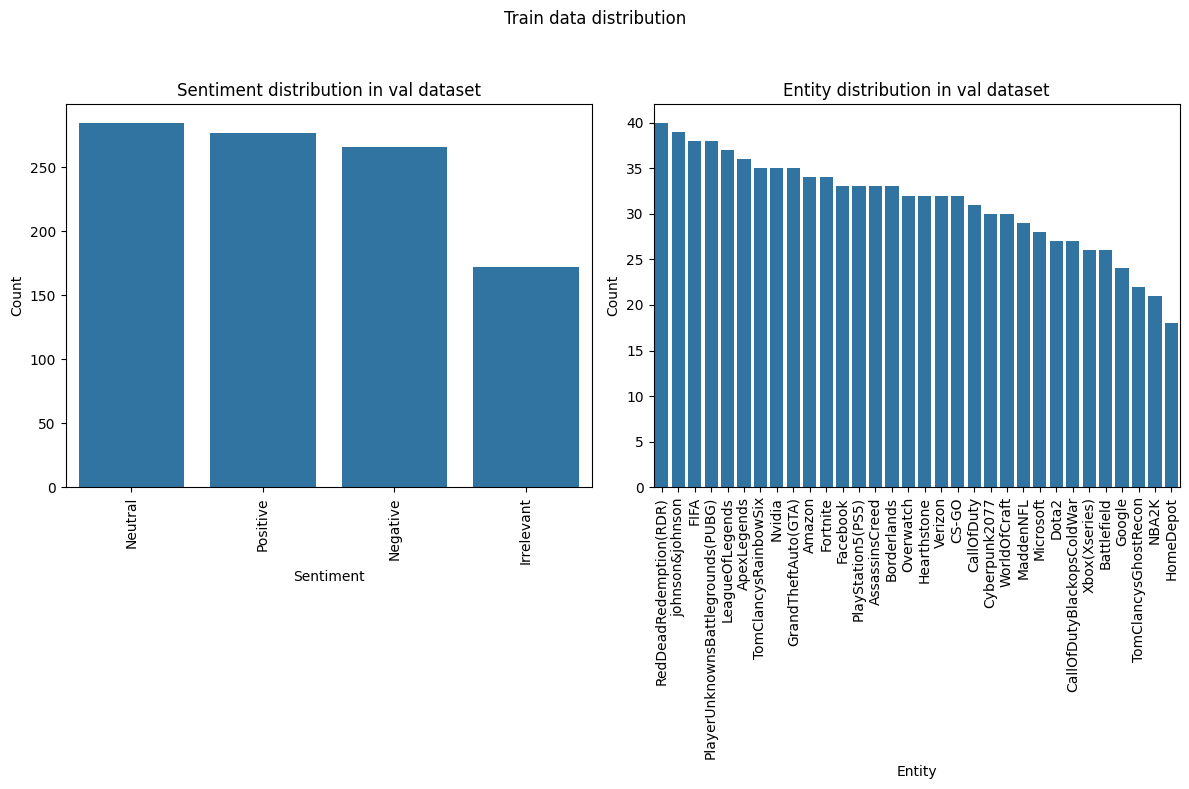

<class 'pandas.core.frame.DataFrame'>
Index: 828 entries, 1 to 999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      828 non-null    int64  
 1   entity  828 non-null    object 
 2   label   828 non-null    object 
 3   text    828 non-null    object 
 4   target  828 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 38.8+ KB


,id,target
count,828.000000,828.000000
mean,6474.440821,1.013285
std,3722.782810,0.810193
min,6.000000,0.000000
25%,3205.500000,0.000000
50%,6800.500000,1.000000
75%,9667.500000,2.000000
max,13197.000000,2.000000


,id,entity,label,text,target
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...,1.0
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...,0.0
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,...",0.0
4,4433,Google,Neutral,Now the President is slapping Americans in the...,1.0
5,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...,0.0


In [7]:
LABELS = ["Negative", "Neutral", "Positive"]  # Ignore the Irrelevant label
LABEL_MAP = {label: i for i, label in enumerate(LABELS)}


def load_split(split: str) -> pd.DataFrame:
    filename = "twitter_training.csv" if split == "train" else "twitter_validation.csv"

    df = pd.read_csv(
        os.path.join(dataset_path, filename),
        names=["id", "entity", "label", "text"],
    ).assign(target=lambda x: x["label"].map(LABEL_MAP))

    print(f"===== {split.capitalize()} dataset =====")

    fig, axes = plt.subplots(1, 2, figsize=(12, 8))
    fig.suptitle("Train data distribution")

    # Plot on axes[0]
    sns.countplot(df, x="label", order=df["label"].value_counts().index, ax=axes[0])
    axes[0].set_title(f"Sentiment distribution in {split} dataset")
    axes[0].set_ylabel("Count")
    axes[0].set_xlabel("Sentiment")
    axes[0].tick_params(axis="x", labelrotation=90)  # Rotating x-ticks for axes[0]

    # Plot on axes[1]
    sns.countplot(df, x="entity", order=df["entity"].value_counts().index, ax=axes[1])
    axes[1].set_title(f"Entity distribution in {split} dataset")
    axes[1].set_ylabel("Count")
    axes[1].set_xlabel("Entity")
    axes[1].tick_params(axis="x", labelrotation=90)  # Rotating x-ticks for axes[1]

    # Display the plot
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit suptitle
    plt.show()

    df = df.dropna(subset=["text", "target"])

    df.info()
    display(df.describe())
    display(df.head())
    return df


train_df = load_split("train")
val_df = load_split("val")

In [8]:
def split_text(text: str) -> list[str]:
    # Split the text into words
    words = re.findall(r"\b\w+\b", text.lower())
    return words

split_text("This is a !somewhat difficult? 1995 'text' to \"split\"")

['this', 'is', 'a', 'somewhat', 'difficult', '1995', 'text', 'to', 'split']

In [9]:
def tokenize(
    inputs: list[str],
    pad_to_max_length: bool = True,
    pad_to_length: int | None = None,
    truncate: int | None = None,
) -> list[list[int]]:
    tokenized_examples = [split_text(x) for x in inputs]

    if pad_to_max_length and not pad_to_length:
        pad_to_length = max(len(x) for x in tokenized_examples)
        pad_to_length = min(pad_to_length, truncate or pad_to_length)

    indexes = []
    for example in tokenized_examples:
        ids = [word2vec_model.key_to_index.get(token, 0) for token in example]
        if truncate:
            ids = ids[:truncate]
        if pad_to_length:
            ids = ids + [0] * (pad_to_length - len(ids))
        indexes.append(ids)
    return indexes

print(train_df.iloc[:2]["text"])
print(split_text(train_df.iloc[0]["text"]))
print(split_text(train_df.iloc[1]["text"]))
tokenize(train_df.iloc[:2]["text"])

0    im getting on borderlands and i will murder yo...
1    I am coming to the borders and I will kill you...
Name: text, dtype: object
['im', 'getting', 'on', 'borderlands', 'and', 'i', 'will', 'murder', 'you', 'all']
['i', 'am', 'coming', 'to', 'the', 'borders', 'and', 'i', 'will', 'kill', 'you', 'all']


[[33935, 421, 5, 152751, 0, 4501, 23, 1693, 43, 52, 0, 0],
 [4501, 248, 471, 0, 11, 5486, 0, 4501, 23, 2176, 43, 52]]

In [10]:
def collate_fn(
    examples: dict[str, list], pad_to_length: int | None = None, truncate: int | None = None
) -> dict[str, torch.Tensor]:
    tokens = torch.tensor(
        tokenize(
            [x["text"] for x in examples],
            pad_to_max_length=True,
            pad_to_length=pad_to_length,
            truncate=truncate,
        )
    )
    labels = F.one_hot(torch.tensor([x["target"] for x in examples], dtype=torch.int64), num_classes=len(LABELS))
    return {"input_ids": tokens, "labels": labels}


collate_fn(train_df.iloc[:4].to_dict(orient="records"))

{'input_ids': tensor([[ 33935,    421,      5, 152751,      0,   4501,     23,   1693,     43,
              52,      0,      0],
         [  4501,    248,    471,      0,     11,   5486,      0,   4501,     23,
            2176,     43,     52],
         [ 33935,    421,      5, 152751,      0,   4501,     23,   2176,     43,
              52,      0,      0],
         [ 33935,    471,      5, 152751,      0,   4501,     23,   1693,     43,
              52,      0,      0]]),
 'labels': tensor([[0, 0, 1],
         [0, 0, 1],
         [0, 0, 1],
         [0, 0, 1]])}

In [11]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        return dict(self.df.iloc[idx].to_dict())
    

train_loader = torch.utils.data.DataLoader(
    Dataset(train_df),
    batch_size=10,
    shuffle=True,
    collate_fn=collate_fn,
)

for batch in train_loader:
    print(batch["input_ids"].shape, batch["labels"].shape)
    print(batch["input_ids"])
    print(batch["labels"])
    break

torch.Size([10, 53]) torch.Size([10, 3])
tensor([[ 171563,    6321,     282,       0,     624,     466,    8303,     640,
             875,       0,       0,       0,       0,       0,       0,       0,
               0,       0,       0,       0,       0,       0,       0,       0,
               0,       0,       0,       0,       0,       0,       0,       0,
               0,       0,       0,       0,       0,       0,       0,       0,
               0,       0,       0,       0,       0,       0,       0,       0,
               0,       0,       0,       0,       0],
        [     58,      32,      52,   26999,       8,    2083,   11860,       0,
               0,       0,       0,       0,       0,       0,       0,       0,
               0,       0,       0,       0,       0,       0,       0,       0,
               0,       0,       0,       0,       0,       0,       0,       0,
               0,       0,       0,       0,       0,       0,       0,       0,
             

In [12]:
from einops import rearrange


class SentimentClassifier(torch.nn.Module):
    def __init__(self, num_tokens: int, embed_dim: int, labels: list[str]):
        super().__init__()
        self.num_tokens = num_tokens
        self.labels = labels
        self.embedding = torch.nn.Embedding.from_pretrained(torch.tensor(word2vec_model.vectors))
        self.linear = torch.nn.Linear(num_tokens * embed_dim, len(labels))

    def forward(self, x):
        x = self.embedding(x)
        x = rearrange(x, "b t e -> b (t e)")
        x = self.linear(x)

        return x
    
    @torch.inference_mode
    def predict(self, inputs: list[str]):
        tokenized = tokenize(inputs, pad_to_length=self.num_tokens, truncate=self.num_tokens)
        tokens = torch.tensor(tokenized, device=self.embedding.weight.device)
        predictions = self(tokens)
        label_ids = torch.argmax(predictions, dim=-1).tolist()
        labels = [self.labels[i] for i in label_ids]
        return labels


batch_size = 10
embed_dim = 300
num_tokens = 20

device = torch.device("cuda")


def fixed_size_collate_fn(examples: dict[str, list]) -> dict[str, torch.Tensor]:
    return collate_fn(examples, pad_to_length=num_tokens, truncate=num_tokens)


train_loader = torch.utils.data.DataLoader(
    Dataset(train_df),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=fixed_size_collate_fn,
)

val_loader = torch.utils.data.DataLoader(
    Dataset(val_df),
    batch_size=batch_size,
    shuffle=False,
    collate_fn=fixed_size_collate_fn,
)

model = SentimentClassifier(num_tokens, embed_dim, LABELS).to(device)
criterion = torch.nn.CrossEntropyLoss()
# Adam has many hyperparameters - play with it!
# Try other optimizers as well!
optimizer = torch.optim.Adam(model.parameters())

# Train the model
# NOTE: always track the validation accuracy to see when it diverges from the training accuracy!
# This is a sign of overfitting!
# In this simple example we omit it for simplicity of the training loop.
num_epochs = 5
for epoch in range(num_epochs):
    train_loss = 0
    model.train()
    for batch in train_loader:
        input_ids = batch["input_ids"][:, :num_tokens].to(device)
        labels = batch["labels"].to(torch.float32).to(device)
        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = criterion(outputs, labels)
        # loss must be a scalar for loss.backward() to work!
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    val_loss = 0
    model.eval()
    with torch.inference_mode():
        for batch in val_loader:
            input_ids = batch["input_ids"][:, :num_tokens].to(device)
            labels = batch["labels"].to(torch.float32).to(device)
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    print(f"Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(val_loader):.4f}")

Epoch 1, Train Loss: 0.8312, Val Loss: 0.6571
Epoch 2, Train Loss: 0.7202, Val Loss: 0.5607
Epoch 3, Train Loss: 0.6852, Val Loss: 0.5439
Epoch 4, Train Loss: 0.6666, Val Loss: 0.5258
Epoch 5, Train Loss: 0.6530, Val Loss: 0.5101


In [13]:
model.predict(
    [
        "I'm gonna kill ya all!",
        "I hate this game!",
        "I will never play again, it's so boring!",
        "Meet me in CS:GO, I'm gonna destroy you!",
        "I love this game, it's so fun!",
    ]
)

['Positive', 'Negative', 'Negative', 'Negative', 'Positive']